In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = 'Series\\'
data = next(os.walk(path), (None, None, []))[2]
data

['daily-total-female-births-in-cal.csv',
 'international-airline-passengers.csv',
 'mean-monthly-air-temperature-deg.csv',
 'monthly-boston-armed-robberies-j.csv',
 'monthly-sales-of-company-x-jan-6.csv',
 'Static_series.csv',
 'weekly-closings-of-the-dowjones-.csv']

In [4]:
def get_series(num):
    series = pd.read_csv(path + data[num]).iloc[:, 1]
    return series

In [8]:
def EMA(y, alpha=0.9):
    output, yhat = [], y[0]

    for y_t in y:
        yhat = alpha * y_t + (1 - alpha) * yhat
        output.append(yhat)
        
    return pd.Series(output)

In [47]:
def DEMA(y, alpha, beta):
    yhat = []
    level, old_level, trend = (0 for _ in range(3))
    for y_t in y:
        level = alpha * y_t + (1 - alpha) * (level + trend)
        trend = beta * (level - old_level) + (1 - beta) * trend
        old_level = level
        yhat.append(level + trend)
    return pd.Series(yhat)

In [16]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    n_seasons = int(len(series)/slen)
    # compute season averages
    season_averages = [sum(series[slen*j:slen*j+slen])/float(slen) for j in range(n_seasons)]
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = sum([series[slen*j+i]-season_averages[j] for j in range(n_seasons)])
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [73]:
def TEMA(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    init_trend_func = lambda series, slen: sum([float(series[i + slen] - series[i]) / slen]) / slen
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = init_trend_func(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return pd.Series(result)

# First series

- Simple EMA

In [101]:
series1 = get_series(5).iloc[:50]

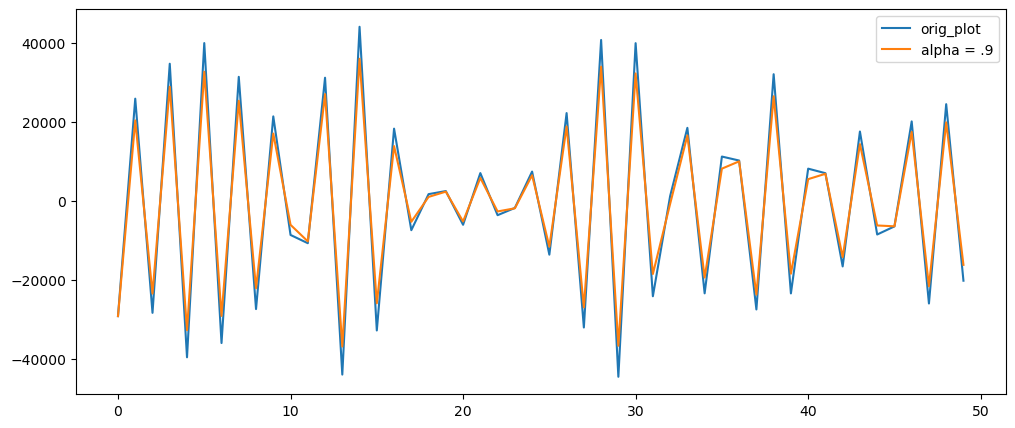

In [102]:
series1.plot(figsize=(12, 5), label='orig_plot')

EMA(series1, .9).plot(label='alpha = .9')
plt.legend()

- Double EMA

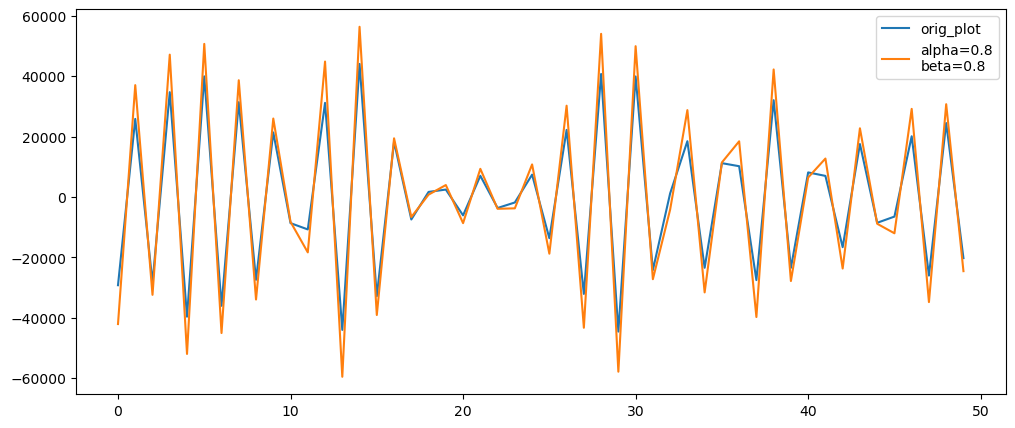

In [66]:
series1.plot(figsize=(12, 5), label='orig_plot')

alpha, beta = .8, .8
DEMA(series1, alpha, beta).plot(label=f'alpha={alpha}\nbeta={beta}')
plt.legend()

- Triple EMA

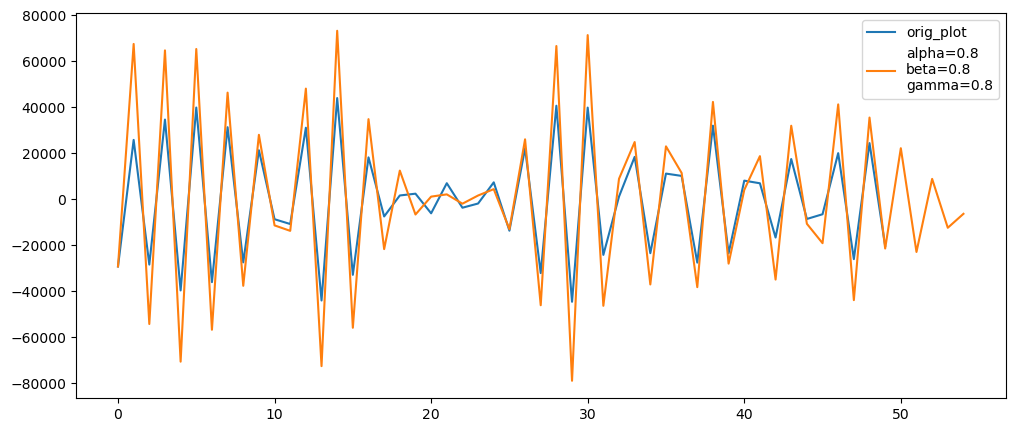

In [78]:
series1.plot(figsize=(12, 5), label='orig_plot')

a, b, g = .8, .8, .8
TEMA(series1, 12, a, b, g, 5).plot(label=f'alpha={a}\nbeta={b}\ngamma={g}')
plt.legend()

# Вывод по первому ряду
- ЕМА хорошо подстроился под график, без опозданий и с небольшими отклонениями
- ДЕМА склонен опаздывать и делать ошибки
- ТЕМА также

- Думаю, что это потому, что у ряда нет временных компонент (тренда и сезонности)

# Seconde series

In [85]:
series2 = get_series(1)

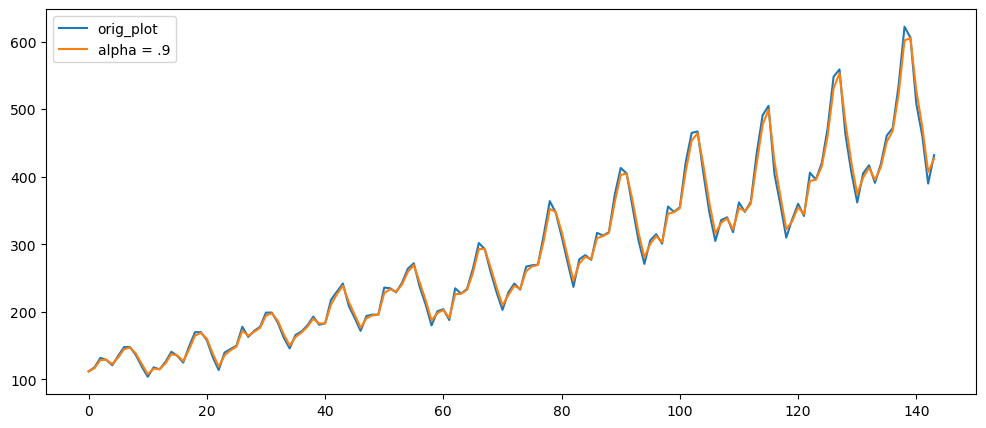

In [86]:
series2.plot(figsize=(12, 5), label='orig_plot')

EMA(series2, .8).plot(label='alpha = .9')
plt.legend()

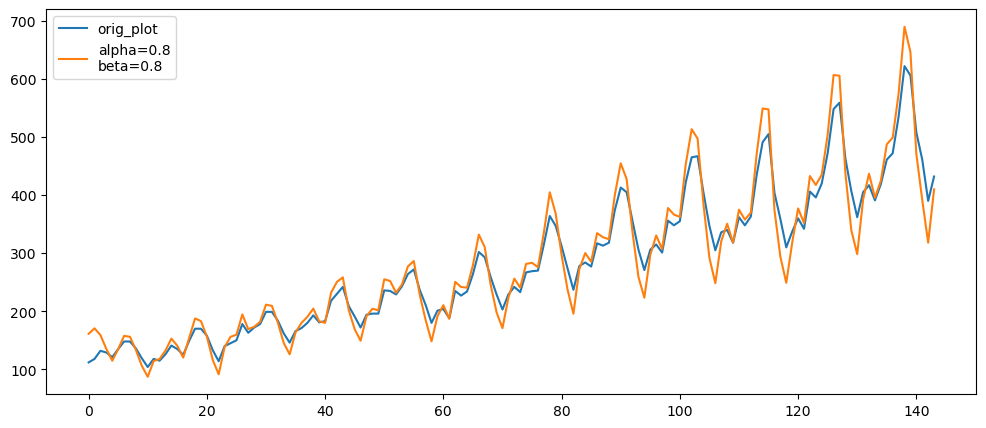

In [87]:
series2.plot(figsize=(12, 5), label='orig_plot')

alpha, beta = .8, .8
DEMA(series2, alpha, beta).plot(label=f'alpha={alpha}\nbeta={beta}')
plt.legend()

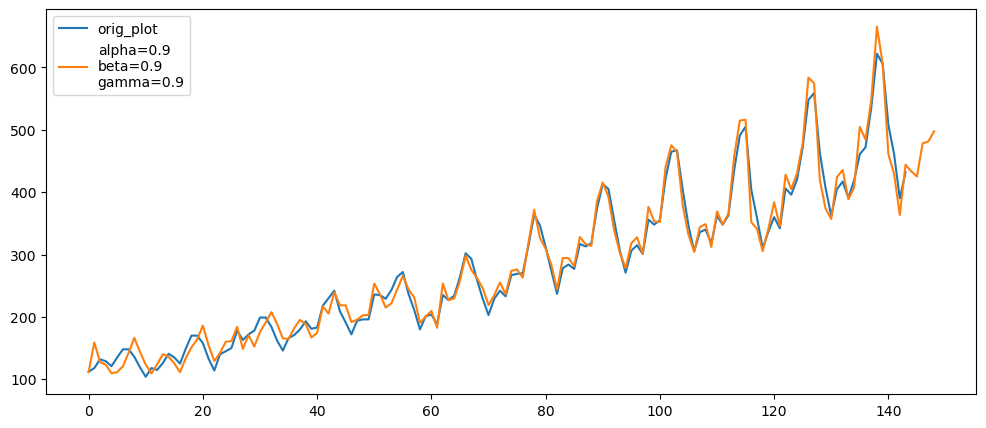

In [107]:
series2.plot(figsize=(12, 5), label='orig_plot')

a, b, g = .9, .9, .9
TEMA(series2, 12, a, b, g, 5).plot(label=f'alpha={a}\nbeta={b}\ngamma={g}')
plt.legend()

# Вывод по второму ряду
- ЕМА почему-то показал неплохие результаты. Думаю, что на предсказании он поломается полностью
- ДЕМА ожидаемо поломался на ряде с сезонностью
- ТЕМА предсказала что-то довольно похожее на правду. С оптимизацией параметров, думаю, модель проявит себя хорошо